## Final Project Submission

Please fill out:
* Student name: John Dean
* Student pace: Part time
* Scheduled project review date/time: 
* Instructor name: Eli Thomas
* Blog post URL:


## Introduction

Microsoft wants to enter the film industry, and is seeking data driven insight into what kinds of films are performing well recently. In this data analysis, we will seek to find the most meaningful business recommendations possible. To this end, we will begin by showing what typical movie budgets might look like and what those budgets tend to bring in terms of return on investment (ROI). We will then look for opportunities for entry by examining the impacts of seasonality, maturity rating, genres, and several combinations of these factors. By the completion of this analysis, our aim is to provide answers for the following core questions:

* What effect does budget have on return on investment, as well as the success rate of films?
* Does seasonality have an impact on the number or types of films that perform well?
* Does maturity rating have a meaningful impact on the likelihood of success for a film?

## Libraries

We will go ahead an import the necessary libraries and get a preliminary understanding of our data. By the end of this preliminary analysis, we should have an idea of what a typical ROI is on films as well as the size of a normal budget. Our libraries will therefore be focused on computation and visualization.

In [2]:
import pandas as pd # library for data analysis
import numpy as np # advanced computation library
import matplotlib.pyplot as plt # library for plotting data
%matplotlib inline
import seaborn as sns # plotting library we will use for histograms
import os # allows us to interface with computer
import sqlite3 # light weight sql library to handle our large data sets
from glob import glob # file path generation tool

## Data Import, Cleaning, and Prep

For importing and cleaning our data, we will be using a process based heavily on the one found here:

https://github.com/Kaguilar1222/dsc-mod-1-project-v2-1-onl01-dtsc-ft-012120/blob/master/student.ipynb

This process provides a scalable solution for creating a sql table for any number of csv files, rather than hard coding file names or sizes into our code. 

In [3]:
#creating a list of the data we will be reading
files = glob('./zippedData/*.csv.gz')
type(files)

list

In [4]:
#cleaning file name
#creating dictionary of dataframes of each csv and tsv
files_dict = {}
for filename in files:
    if 'csv' in str(os.path.basename(filename)):
        filename_cleaned = os.path.basename(filename).replace(".csv.gz", "").replace(".", "_")
        filename_df = pd.read_csv(filename, compression='gzip', index_col=0)
        files_dict[filename_cleaned] = filename_df

In [5]:
#viewing file names from k:v pairs in our dictionary
files_dict.keys()

dict_keys(['imdb_title_basics', 'imdb_title_ratings', 'tn_movie_budgets'])

In [6]:
#checking a key in the dictionary to ensure that dataframes have been created 
files_dict['tn_movie_budgets'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null object
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null object
dtypes: object(5)
memory usage: 271.0+ KB


We have some columns in our data that are not in the format we would like them to be in. We will need to format them before passing them to our sql database for queries. 

In [7]:
#converting types of series that are not formatted as we would like
files_dict['imdb_title_basics']['primary_title'] = files_dict['imdb_title_basics']['primary_title'].astype(str) 
files_dict['imdb_title_basics']['original_title'] = files_dict['imdb_title_basics']['original_title'].astype(str)
files_dict['imdb_title_basics']['genres'] = files_dict['imdb_title_basics']['genres'].astype(str) 


In [8]:
# converting the comma separated string of genres into lists
files_dict['imdb_title_basics']['genres'] = files_dict['imdb_title_basics']['genres'].str.split(pat = ',')
files_dict['imdb_title_basics']['genres']

tconst
tt0063540      [Action, Crime, Drama]
tt0066787          [Biography, Drama]
tt0069049                     [Drama]
tt0069204             [Comedy, Drama]
tt0100275    [Comedy, Drama, Fantasy]
                       ...           
tt9916538                     [Drama]
tt9916622               [Documentary]
tt9916706                    [Comedy]
tt9916730                       [nan]
tt9916754               [Documentary]
Name: genres, Length: 146144, dtype: object

In [9]:
# making sure the release dates are datetime dtype
files_dict['tn_movie_budgets']['release_date'] = pd.to_datetime(files_dict['tn_movie_budgets']['release_date'])
files_dict['tn_movie_budgets']['release_date']

id
1    2009-12-18
2    2011-05-20
3    2019-06-07
4    2015-05-01
5    2017-12-15
        ...    
78   2018-12-31
79   1999-04-02
80   2005-07-13
81   2015-09-29
82   2005-08-05
Name: release_date, Length: 5782, dtype: datetime64[ns]

In [10]:
# scrubbing extra characters and converting to int
files_dict['tn_movie_budgets']['production_budget'] = files_dict['tn_movie_budgets']['production_budget'].astype(str)
files_dict['tn_movie_budgets']['production_budget'] = files_dict['tn_movie_budgets']['production_budget'].str.replace('$', '')
files_dict['tn_movie_budgets']['production_budget'] = files_dict['tn_movie_budgets']['production_budget'].str.replace(',', '')
files_dict['tn_movie_budgets']['production_budget'] = pd.to_numeric(files_dict['tn_movie_budgets']['production_budget'])
files_dict['tn_movie_budgets']['domestic_gross'] = files_dict['tn_movie_budgets']['domestic_gross'].astype(str)
files_dict['tn_movie_budgets']['domestic_gross'] = files_dict['tn_movie_budgets']['domestic_gross'].str.replace('$', '')
files_dict['tn_movie_budgets']['domestic_gross'] = files_dict['tn_movie_budgets']['domestic_gross'].str.replace(',', '')
files_dict['tn_movie_budgets']['domestic_gross'] = pd.to_numeric(files_dict['tn_movie_budgets']['domestic_gross'])
files_dict['tn_movie_budgets']['worldwide_gross'] = files_dict['tn_movie_budgets']['worldwide_gross'].astype(str)
files_dict['tn_movie_budgets']['worldwide_gross'] = files_dict['tn_movie_budgets']['worldwide_gross'].str.replace('$', '')
files_dict['tn_movie_budgets']['worldwide_gross'] = files_dict['tn_movie_budgets']['worldwide_gross'].str.replace(',', '')
files_dict['tn_movie_budgets']['worldwide_gross'] = pd.to_numeric(files_dict['tn_movie_budgets']['worldwide_gross'])

In [11]:
files_dict['tn_movie_budgets']['production_budget']

id
1     425000000
2     410600000
3     350000000
4     330600000
5     317000000
        ...    
78         7000
79         6000
80         5000
81         1400
82         1100
Name: production_budget, Length: 5782, dtype: int64

In [12]:
#connecting to new database
conn = sqlite3.connect("movies_db.sqlite")

In [13]:
#creating function to create a SQL table passing a dataframe, name, and 
#connection to database
def create_sql_table_from_df(df, name, conn):
    try:
        df.to_sql(name, conn)
        print(f"Created table {name}")
    except Exception as e:
        print(f"could not make table {name}")
        print(e)

In [14]:
#passing the function through a for loop of the tables and names in our 
#dictionary of csv files
for name, table in files_dict.items():
    create_sql_table_from_df(table, name, conn)

could not make table imdb_title_basics
Table 'imdb_title_basics' already exists.
could not make table imdb_title_ratings
Table 'imdb_title_ratings' already exists.
could not make table tn_movie_budgets
Table 'tn_movie_budgets' already exists.


In [15]:
#creating a cursor to do a query of our sql db
cur = conn.cursor()

In [16]:
#testing connection on our database of tables
conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

[('imdb_title_basics',), ('imdb_title_ratings',), ('tn_movie_budgets',)]

## Initial Analysis

Before we can figure out how different factors impact our returns, we need to know what our returns generally will look like overall. For this, we will first find a distribution for budgets across the industry, then we will try to find patterns or trends on those budgets across genres and seasons of release. For the purposes of this analysis, we want to try and maximize our return on investment, so we will ultimately be seeking opportunities to do that.

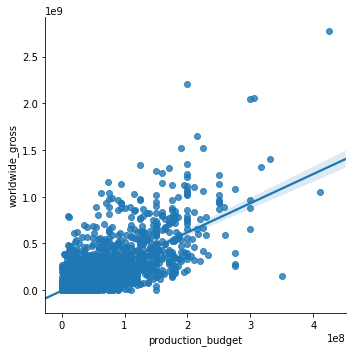

In [36]:
sns.lmplot('production_budget', 'worldwide_gross',
          data = files_dict['tn_movie_budgets'])

Okay, not super useful. We can at least tell that as budgets increase, it seems that so does the gross revenue. Next we're going to try to find what the ROI looks like across the same data set. To do this, we will begin by adding a "profit" column to our data, then dividing the budget by that profit. Once that's completed, we'll repeat our scatter plot using the ROI instead of worldwide revenue.

In [69]:
files_dict['tn_movie_budgets']['production_budget'].keys()

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            73, 74, 75, 76, 77, 78, 79, 80, 81, 82],
           dtype='int64', name='id', length=5782)

In [51]:
profits = [get_profit(movie)
           for movie
           in files_dict['tn_movie_budgets']]
files_dict['tn_movie_budgets']['profits'] = profits
files_dict['tn_movie_budgets'].head()

TypeError: string indices must be integers